In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import zscore
from scipy.interpolate import interp1d
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
from sklearn.multioutput import MultiOutputRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
import pickle

In [3]:
df = pd.read_csv("merged_table_23-24_with_null.csv", encoding="ISO-8859-1")

In [4]:
df['time'] = pd.to_datetime(df['time'], format='%m/%d/%y %H:%M')

In [5]:
# Iterate over the columns with object data type and apply the transformations
for column in df.select_dtypes(include=['object']).columns:
    df[column] = df[column].str.replace(r'\s+', '', regex=True)
    df[column] = df[column].replace('', np.nan)
    df[column] = df[column].astype(float)

In [6]:
df.dtypes

time                datetime64[ns]
ni_in                      float64
fe_in                      float64
sio2_in                    float64
cao_in                     float64
mgo_in                     float64
al2o3_in                   float64
fe_ni                      float64
s_m                        float64
bc                         float64
loi_in                     float64
mc_kilnfeed                float64
fc_coal                    float64
gcv_coal                   float64
voltage_pry                float64
voltage_sec                float64
current_pry                float64
current_sec1               float64
current_sec2               float64
current_sec3               float64
load                       float64
power_factor               float64
realisasi_beban            float64
rpm                        float64
kg_tco                     float64
charge_kiln                float64
tdo                        float64
pry_p                      float64
sec_p               

In [7]:
print(df.isnull().sum())

time                   0
ni_in               4803
fe_in               4802
sio2_in             4802
cao_in              4802
mgo_in              4802
al2o3_in            4802
fe_ni               4803
s_m                 4802
bc                  4802
loi_in              8782
mc_kilnfeed            1
fc_coal             6624
gcv_coal            6624
voltage_pry          779
voltage_sec          510
current_pry          750
current_sec1         503
current_sec2         503
current_sec3         503
load                 498
power_factor         811
realisasi_beban      498
rpm                  745
kg_tco              5036
charge_kiln          256
tdo                    1
pry_p                256
sec_p                256
pry_v                256
sec_v                256
total_coal           284
total_fuel          4934
a_f_ratio           2100
reductor_consume     743
t_tic162            1112
t_tic163            1112
metal_temp          1179
ni_met              1177
c_met               1177


In [8]:
# Define the time ranges
start_range1 = pd.to_datetime('2024-07-31 01:00 AM')
end_range1 = pd.to_datetime('2024-07-31 03:00 PM')
start_range2 = pd.to_datetime('2024-08-01 12:00 AM')
end_range2 = pd.to_datetime('2024-11-12 11:00 PM')

# Filter the DataFrame to include only the specified time ranges
intersection_df = df[((df['time'] >= start_range1) & (df['time'] <= end_range1)) | ((df['time'] >= start_range2) & (df['time'] <= end_range2))]

# Display the filtered DataFrame
print(intersection_df.shape)

(2511, 48)


In [9]:
# Save the filtered data to a new CSV file (optional)
intersection_df.to_csv('filtered_intersection_df.csv', index=False)

In [10]:
print(intersection_df.isnull().sum())

time                   0
ni_in                  0
fe_in                  0
sio2_in                0
cao_in                 0
mgo_in                 0
al2o3_in               0
fe_ni                  0
s_m                    0
bc                     0
loi_in              2511
mc_kilnfeed            1
fc_coal             1815
gcv_coal            1815
voltage_pry            1
voltage_sec            1
current_pry            2
current_sec1           1
current_sec2           1
current_sec3           1
load                   0
power_factor           3
realisasi_beban        0
rpm                    0
kg_tco                23
charge_kiln            8
tdo                    1
pry_p                  8
sec_p                  8
pry_v                  8
sec_v                  8
total_coal             8
total_fuel             8
a_f_ratio            124
reductor_consume       0
t_tic162               0
t_tic163               0
metal_temp             3
ni_met                 1
c_met                  1


In [11]:
input_cols = intersection_df.columns[intersection_df.columns.get_loc('ni_in'):intersection_df.columns.get_loc('t_tic163') + 1]
output_cols = intersection_df.columns[intersection_df.columns.get_loc('metal_temp'):intersection_df.columns.get_loc('loi_kalsin') + 1]
smelting_cols = intersection_df.columns[intersection_df.columns.get_loc('voltage_pry'):intersection_df.columns.get_loc('realisasi_beban') + 1]

In [12]:
intersection_df[output_cols] = intersection_df[output_cols].shift(-16)
intersection_df = intersection_df.iloc[:-16]

# Reset the index
intersection_df.reset_index(drop=True, inplace=True)

C:\Users\rianr\AppData\Local\Temp\ipykernel_31208\3846504361.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  intersection_df[output_cols] = intersection_df[output_cols].shift(-16)


In [13]:
filtered_intersection_df = intersection_df.drop(columns=['loi_in', 'fc_coal', 'gcv_coal', 'fe_ni', 'sio2_in', 'mgo_in', 'voltage_pry', 'voltage_sec'])

In [14]:
print(filtered_intersection_df.isnull().sum())

time                  0
ni_in                 0
fe_in                 0
cao_in                0
al2o3_in              0
s_m                   0
bc                    0
mc_kilnfeed           1
current_pry           2
current_sec1          1
current_sec2          1
current_sec3          1
load                  0
power_factor          3
realisasi_beban       0
rpm                   0
kg_tco               22
charge_kiln           8
tdo                   1
pry_p                 8
sec_p                 8
pry_v                 8
sec_v                 8
total_coal            8
total_fuel            8
a_f_ratio           123
reductor_consume      0
t_tic162              0
t_tic163              0
metal_temp            3
ni_met                1
c_met                 1
si_met                1
fe_met                1
s_met                 1
ni_slag               3
fe_slag               3
t_kalsin              0
pic_161               0
loi_kalsin          817
dtype: int64


## Interpolation

### Function

In [15]:
def interpolate(df, column):
    # Convert the index to numerical values for interpolation
    x = np.arange(len(df))
    y = df[column].values

    # Identify the indices of the non-null values
    non_null_indices = np.where(~np.isnan(y))[0]

    # Perform polynomial interpolation using scipy's interp1d
    poly_interp = interp1d(non_null_indices, y[non_null_indices], kind='cubic', fill_value="extrapolate")

    # Interpolate the null values
    y_interp = poly_interp(x)

    # Create a single figure with two subplots
    plt.figure(figsize=(12, 4))

    # Plot the original data
    plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
    plt.plot(df['time'], y, marker='o', linestyle='-', label='Original Data')
    plt.title('Original Data: ' + column)
    plt.xlabel('Time')
    plt.ylabel(column)
    plt.grid(True)
    plt.legend()

    # Plot the interpolated data
    plt.subplot(1, 2, 2)  # 1 row, 2 columns, second subplot
    plt.plot(df['time'], y, 'o', label='Original Data')
    plt.plot(df['time'], y_interp, '-', label='Interpolated Data')
    plt.title('Interpolated Data: ' + column)
    plt.xlabel('Time')
    plt.ylabel(column)
    plt.grid(True)
    plt.legend()

    # Display the plots
    plt.tight_layout()
    plt.show()

    # Update the DataFrame with the interpolated values
    df[column] = y_interp

### Loop

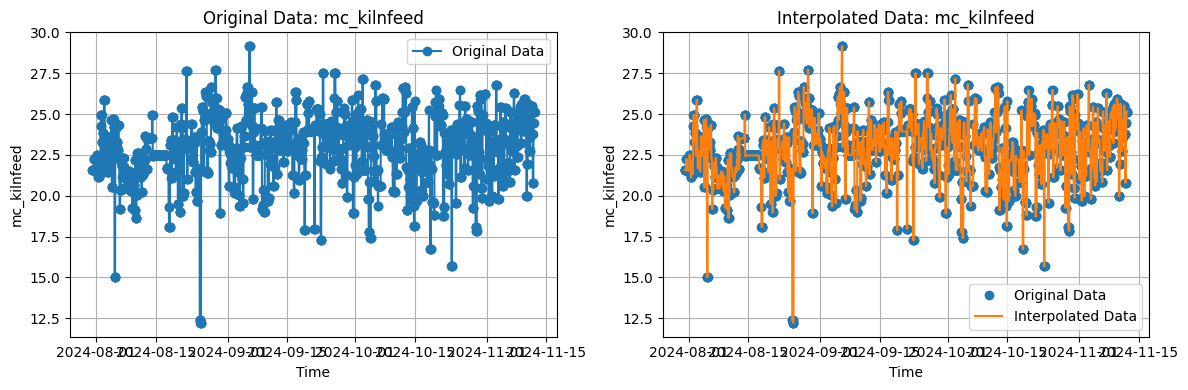

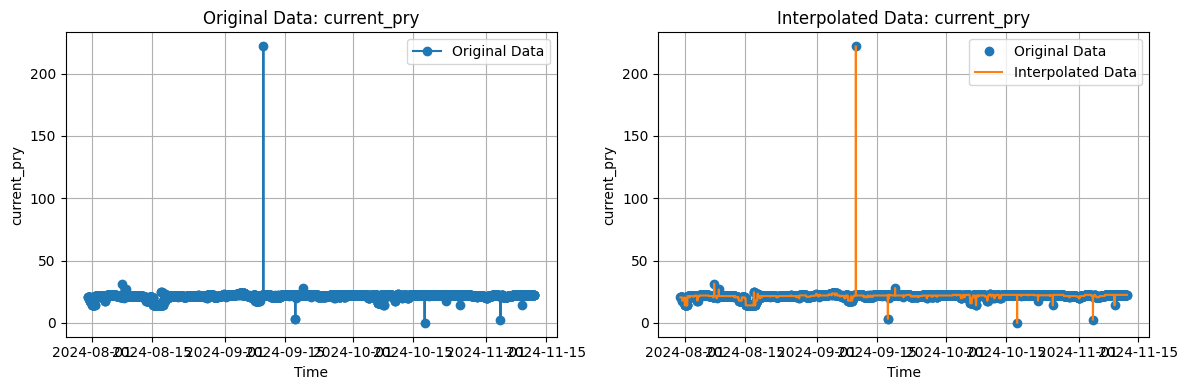

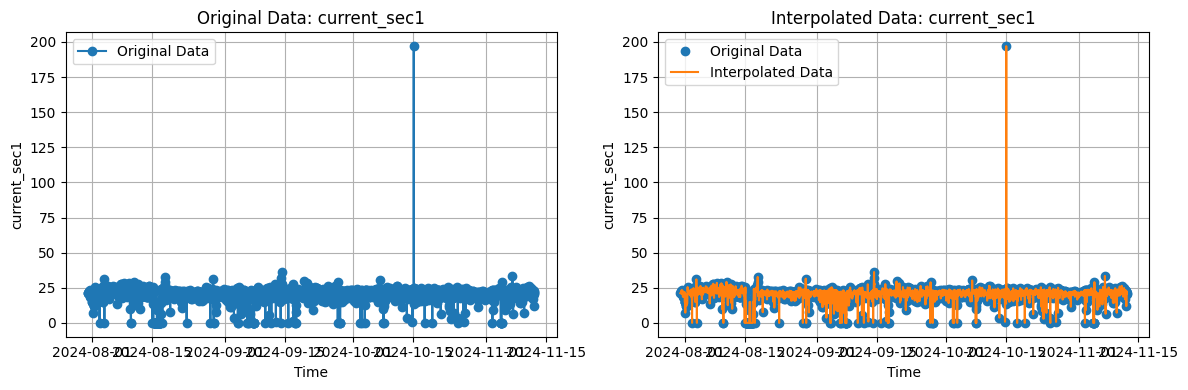

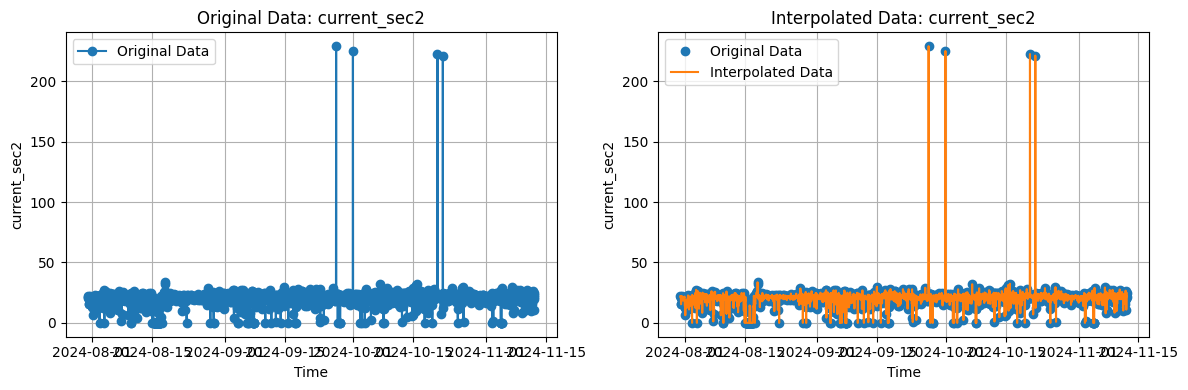

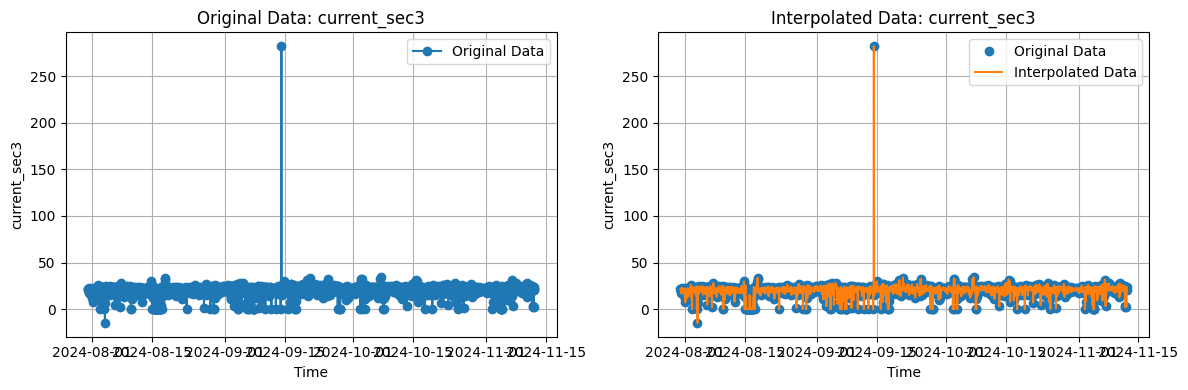

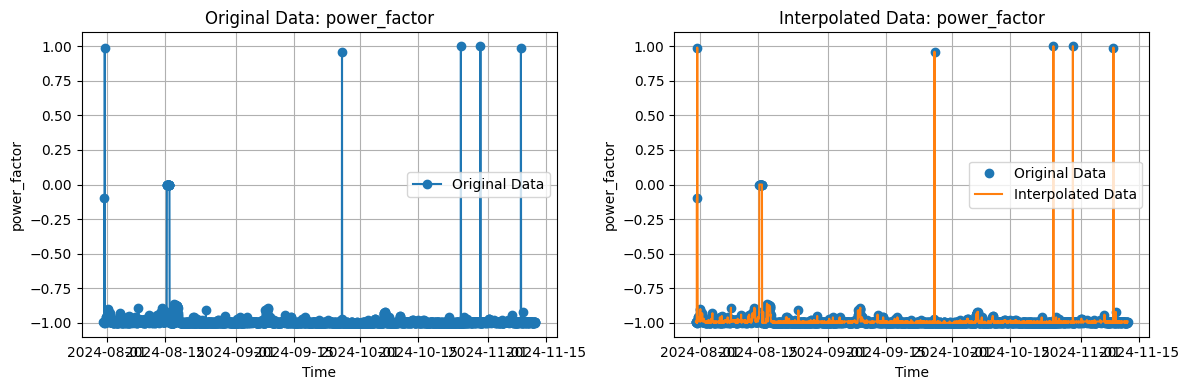

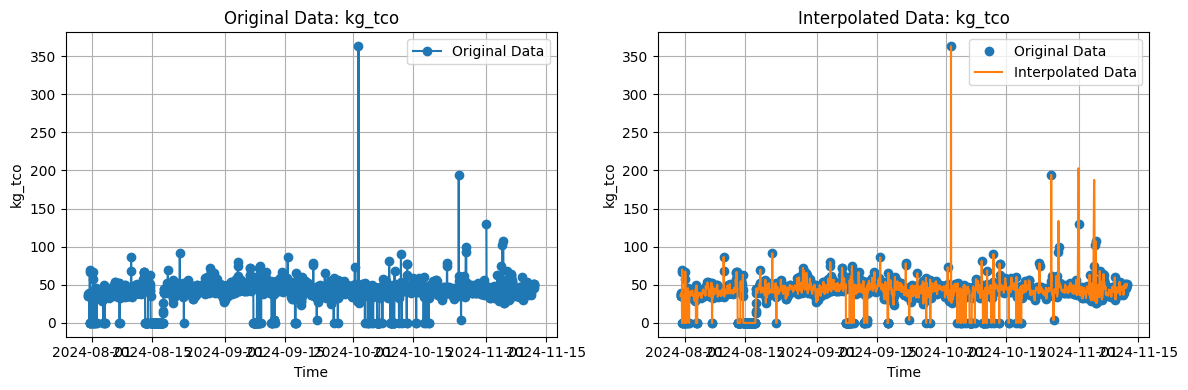

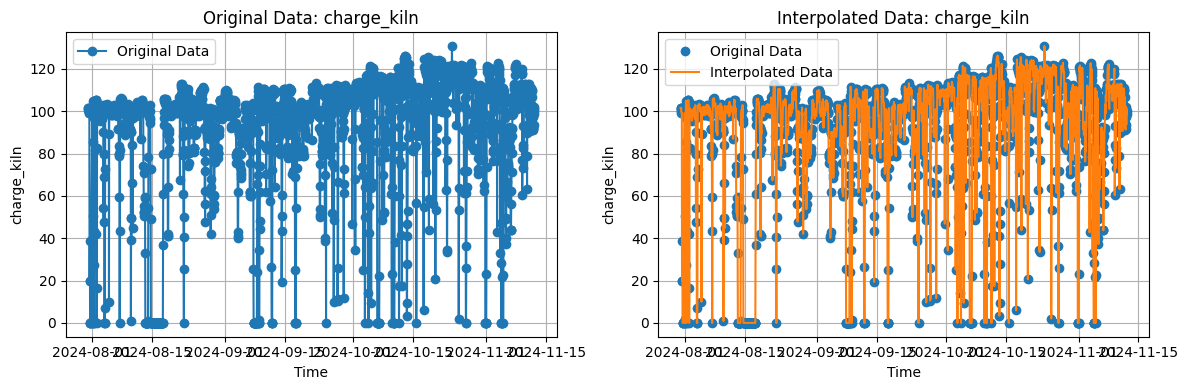

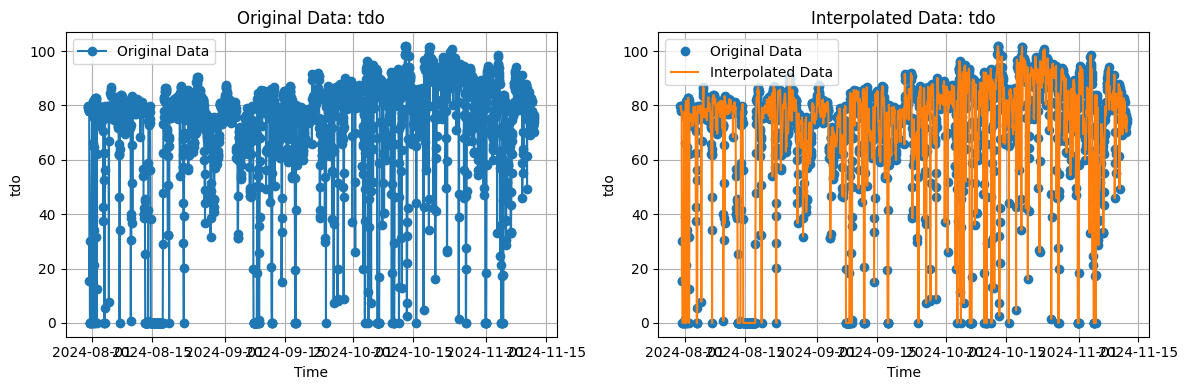

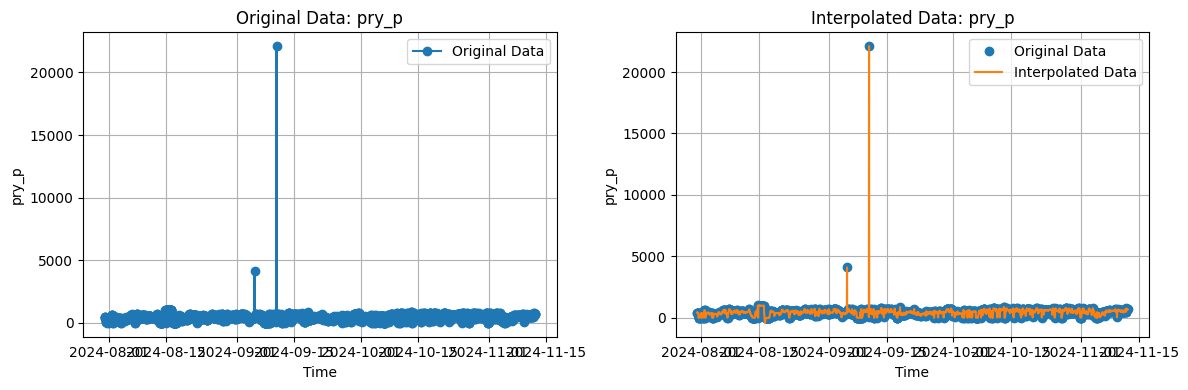

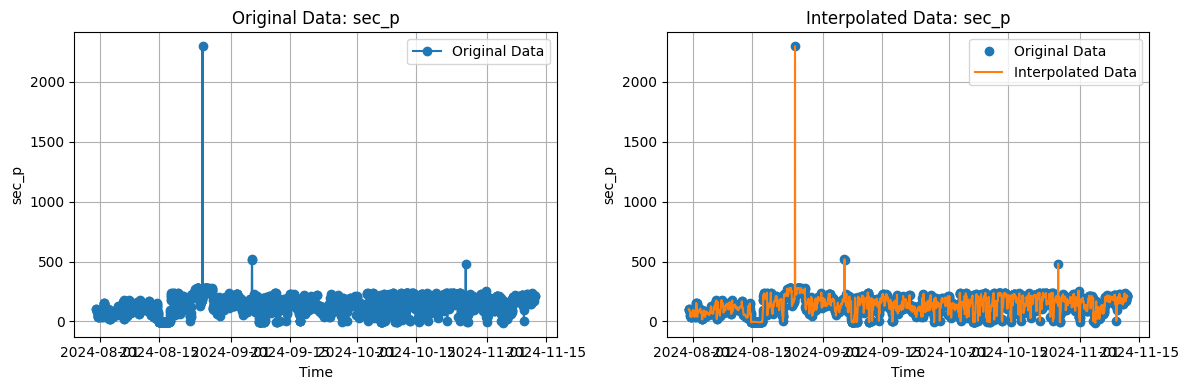

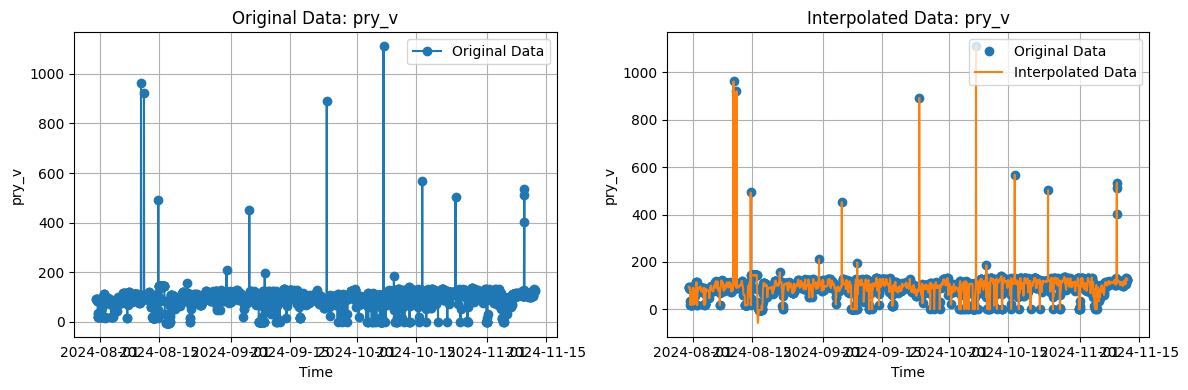

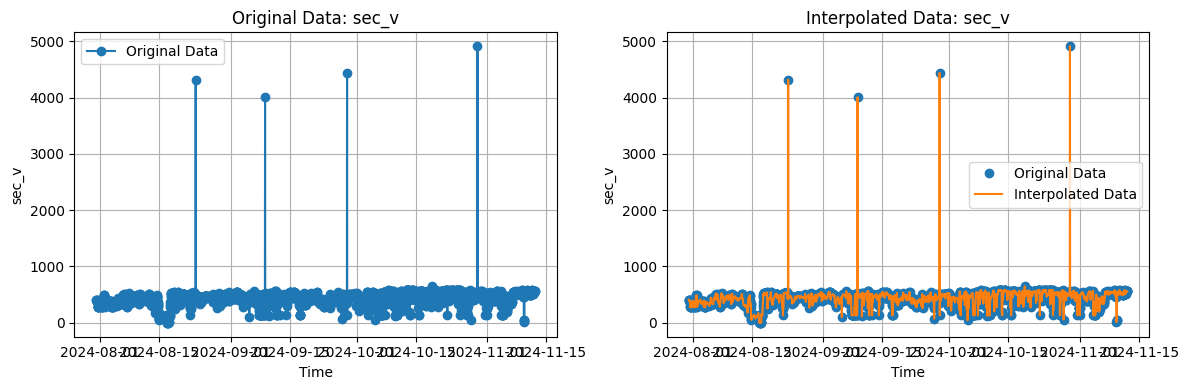

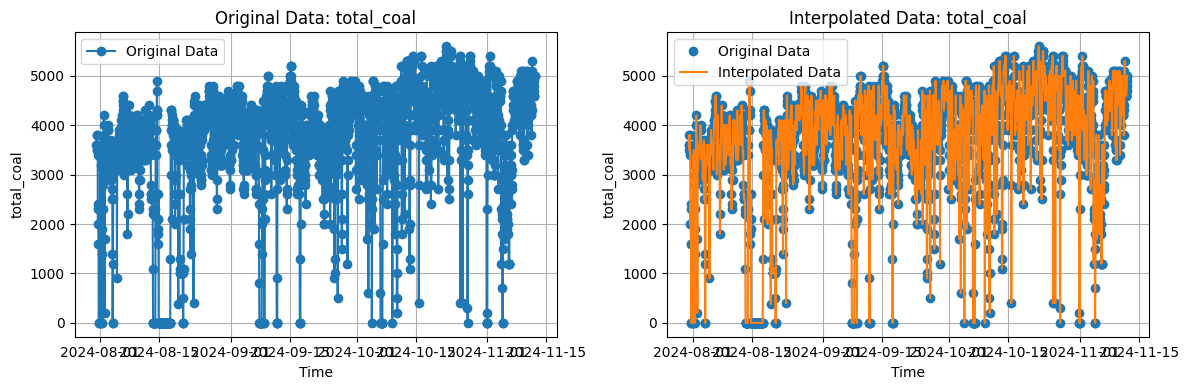

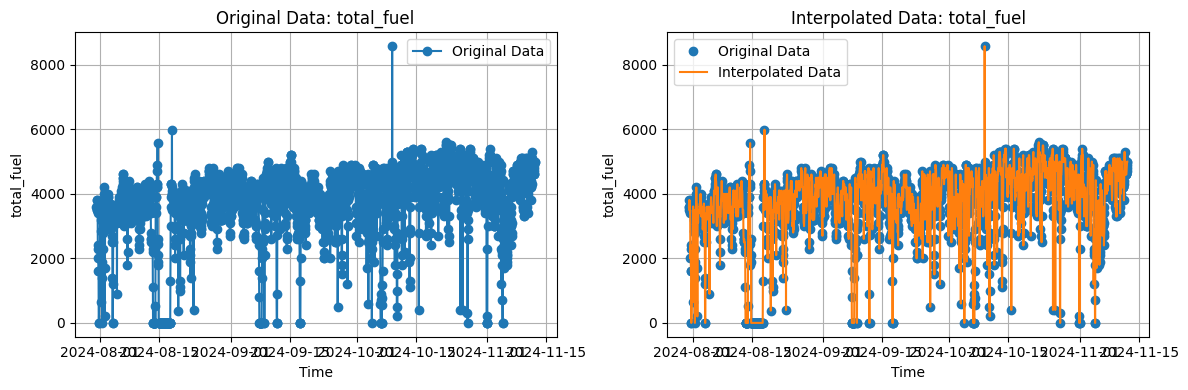

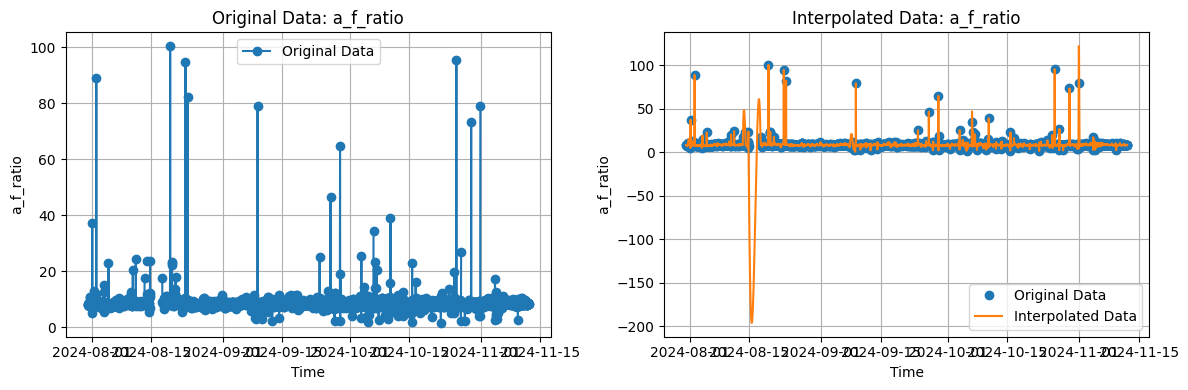

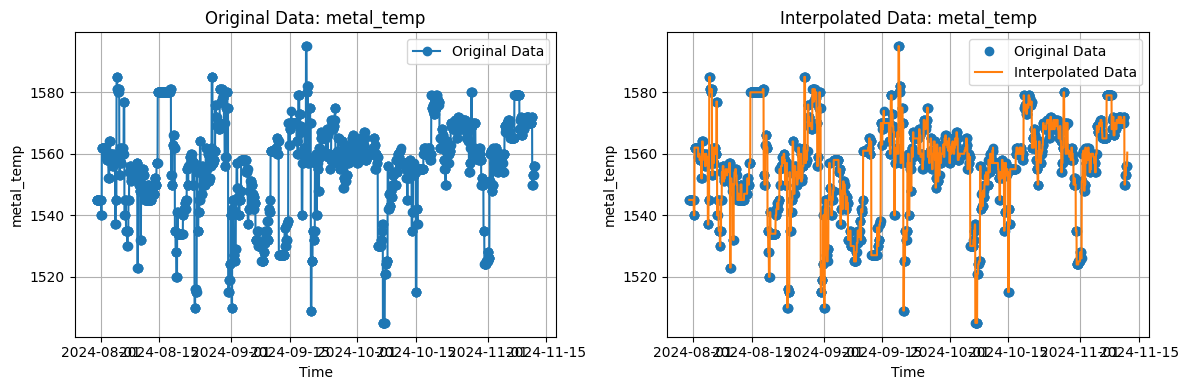

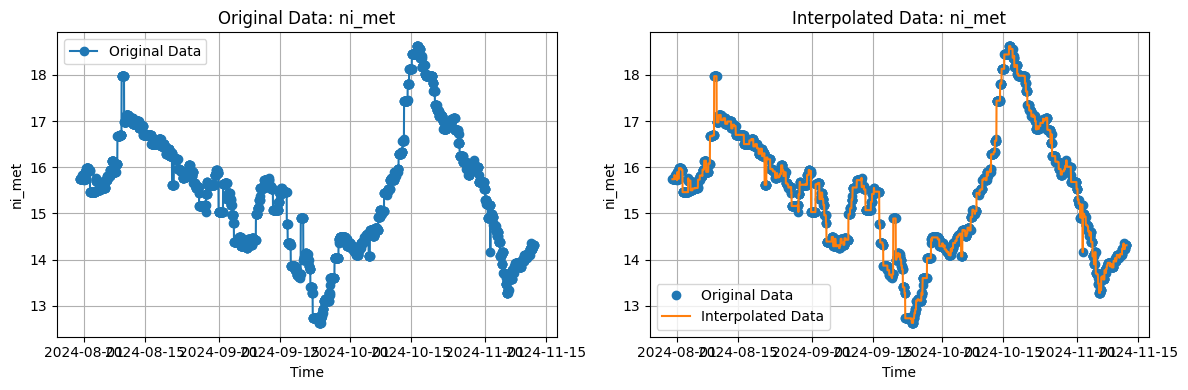

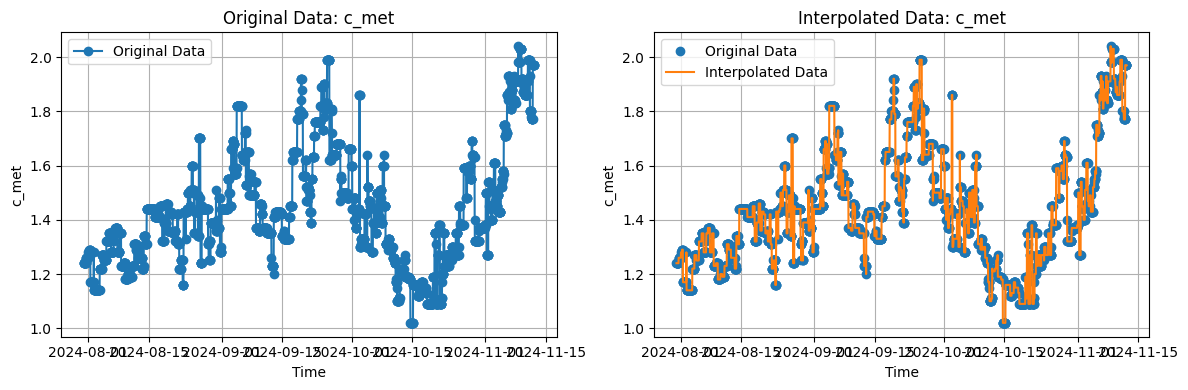

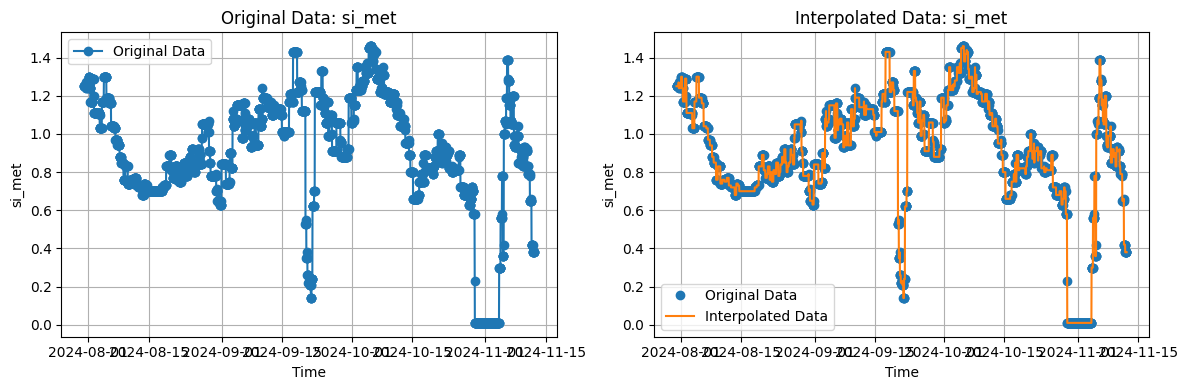

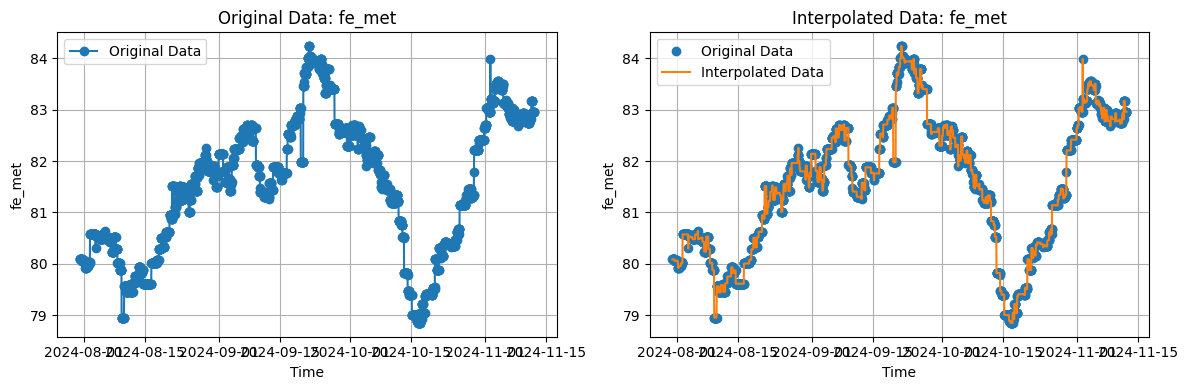

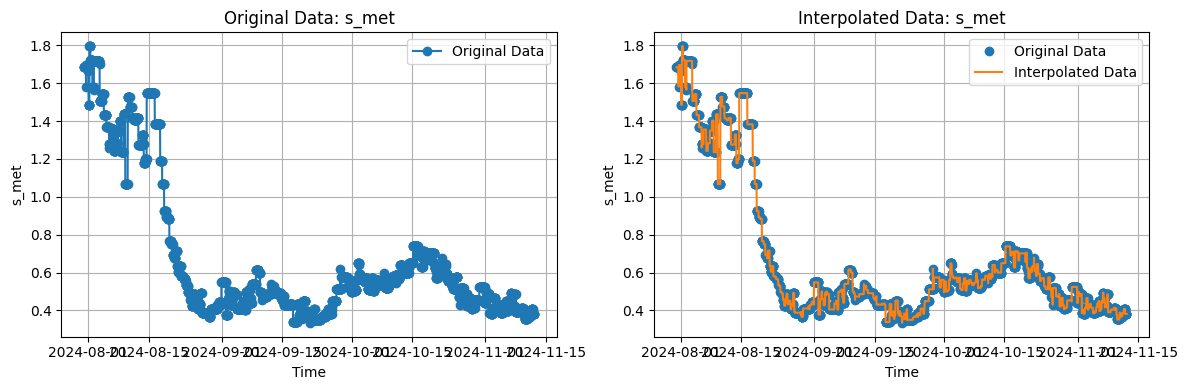

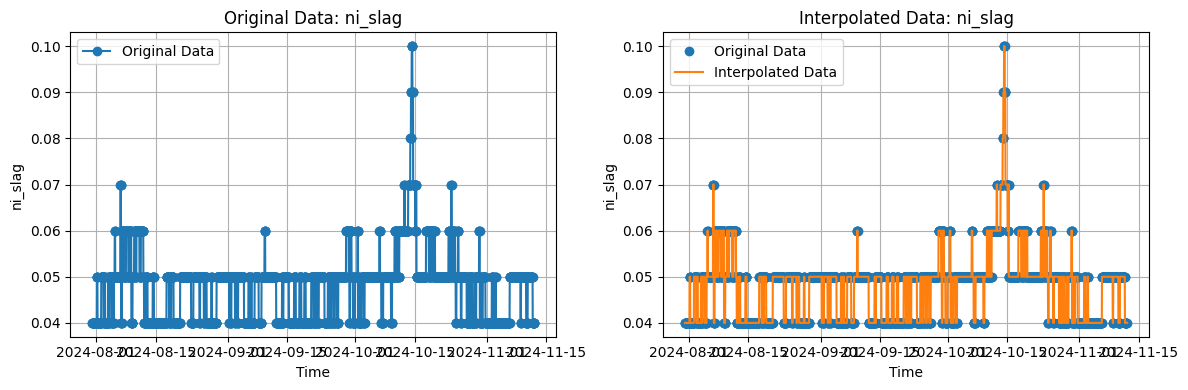

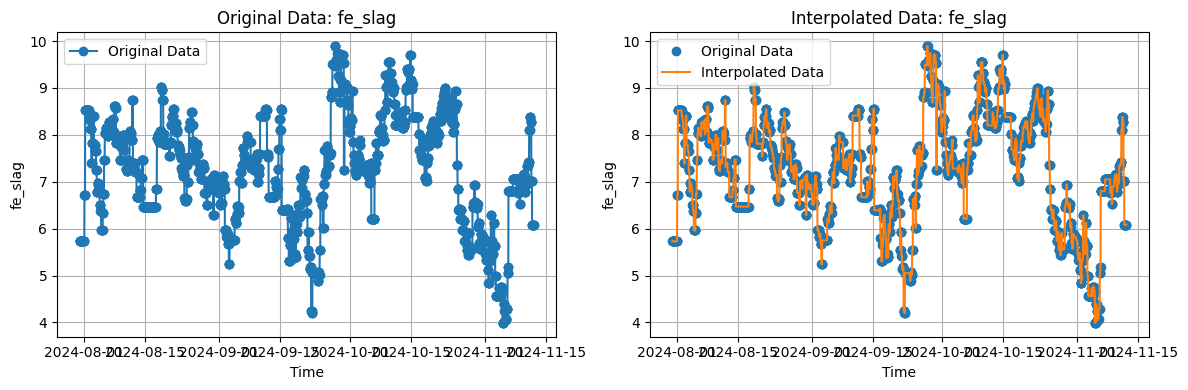

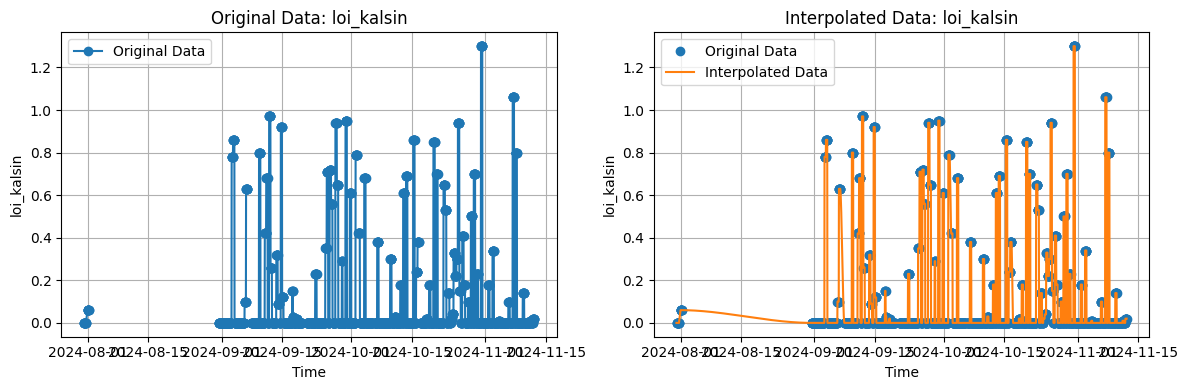

In [16]:
for column in filtered_intersection_df.columns:
    if filtered_intersection_df[column].isnull().any():
        interpolate(filtered_intersection_df, column)

### Result

In [17]:
print(filtered_intersection_df.isnull().sum())

time                0
ni_in               0
fe_in               0
cao_in              0
al2o3_in            0
s_m                 0
bc                  0
mc_kilnfeed         0
current_pry         0
current_sec1        0
current_sec2        0
current_sec3        0
load                0
power_factor        0
realisasi_beban     0
rpm                 0
kg_tco              0
charge_kiln         0
tdo                 0
pry_p               0
sec_p               0
pry_v               0
sec_v               0
total_coal          0
total_fuel          0
a_f_ratio           0
reductor_consume    0
t_tic162            0
t_tic163            0
metal_temp          0
ni_met              0
c_met               0
si_met              0
fe_met              0
s_met               0
ni_slag             0
fe_slag             0
t_kalsin            0
pic_161             0
loi_kalsin          0
dtype: int64


In [18]:
filtered_intersection_df.shape

(2495, 40)

In [19]:
filtered_intersection_df.to_excel('filtered_intersection_df_interpolated.xlsx', index=False)

In [20]:
min_max_df = filtered_intersection_df.agg(['min', 'max']).transpose()

# Display the min and max values for each column
print(min_max_df)

                                  min                  max
time              2024-07-31 01:00:00  2024-11-12 07:00:00
ni_in                            1.33                 2.09
fe_in                           11.95                23.62
cao_in                           0.36                  3.5
al2o3_in                          1.0                 4.24
s_m                          1.471361             3.646552
bc                           0.292244             0.694697
mc_kilnfeed                     12.22                29.16
current_pry                      -0.0               221.97
current_sec1                     -0.0                197.0
current_sec2                     -0.0                229.0
current_sec3                    -14.8                282.2
load                            -22.4                94.82
power_factor                     -1.0                  1.0
realisasi_beban                   0.0              93.8718
rpm                         -0.001485             1.1114

## Model Training


In [21]:
data_df = filtered_intersection_df.copy()
print(data_df.shape)

(2495, 40)


### Normalization

In [22]:
# Initialize the RobustScaler
scaler = RobustScaler()

# Apply Robust Scaling to the DataFrame
scaled_data = scaler.fit_transform(data_df.drop(columns=['time']))

# Convert the scaled data back to a DataFrame
scaled_data_df = pd.DataFrame(scaled_data, columns=data_df.drop(columns=['time']).columns)

### Training

In [23]:
input_cols = scaled_data_df.columns[scaled_data_df.columns.get_loc('ni_in'):scaled_data_df.columns.get_loc('t_tic163') + 1]
output_cols = scaled_data_df.columns[scaled_data_df.columns.get_loc('metal_temp'):scaled_data_df.columns.get_loc('loi_kalsin') + 1]

In [28]:
# Define split configurations
split_ratios = [0.1, 0.2, 0.3, 0.4]

# Initialize models
models = {
    'RandomForest': RandomForestRegressor(),
    'MLP': MLPRegressor(),
    'SVR': MultiOutputRegressor(SVR()),
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'kNN': KNeighborsRegressor(),
    'GPR': GaussianProcessRegressor(),
    'XGBoost': XGBRegressor(),
    'CatBoost': MultiOutputRegressor(CatBoostRegressor(verbose=0))
}

# Function to calculate metrics
def calculate_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred, multioutput='uniform_average')  # Average across outputs
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred, multioutput='uniform_average')
    return mse, rmse, mae

# Iterate over split ratios
for test_size in split_ratios:
    print(f"Split ratio: {int((1 - test_size) * 100)}:{int(test_size * 100)}")
    
    # Split the data
    X = scaled_data_df[input_cols]
    y = scaled_data_df[output_cols]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    
    y_train = y_train.values
    y_test = y_test.values

    # Initialize results for this split ratio
    results_mse, results_rmse, results_mae = [], [], []
    
    # Train each model
    for name, model in models.items():
        print(f"Training {name}...")
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        # Inverse transform y_test and y_pred to original scale
        y_test_original = scaler.inverse_transform(np.hstack([X_test, y_test]))[:, len(input_cols):]
        y_pred_original = scaler.inverse_transform(np.hstack([X_test, y_pred]))[:, len(input_cols):]
        
        # Calculate metrics for each target
        for col_idx, col_name in enumerate(output_cols):
            mse = mean_squared_error(y_test_original[:, col_idx], y_pred_original[:, col_idx])
            rmse = np.sqrt(mse)
            mae = mean_absolute_error(y_test_original[:, col_idx], y_pred_original[:, col_idx])
            
            # Append results
            results_mse.append([name, col_name, mse])
            results_rmse.append([name, col_name, rmse])
            results_mae.append([name, col_name, mae])

        if name == 'XGBoost':
            # Save the XGBoost model in pkl format
            with open(f'xgboost_model_{int((1 - test_size) * 100)}_{int(test_size * 100)}.pkl', 'wb') as file:
                pickle.dump(model, file)

    # Train the GRU model
    gru_model = Sequential()
    gru_model.add(GRU(50, input_shape=(X_train.shape[1], 1)))
    gru_model.add(Dense(y_train.shape[1]))
    gru_model.compile(optimizer='adam', loss='mse')

    # Reshape data for GRU
    X_train_gru = X_train.values.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test_gru = X_test.values.reshape(X_test.shape[0], X_test.shape[1], 1)

    gru_model.fit(X_train_gru, y_train, epochs=10, batch_size=32, verbose=0)
    y_pred_gru = gru_model.predict(X_test_gru)
    
    # Inverse transform GRU predictions
    y_test_original = scaler.inverse_transform(np.hstack([X_test, y_test]))[:, len(input_cols):]
    y_pred_gru_original = scaler.inverse_transform(np.hstack([X_test, y_pred_gru]))[:, len(input_cols):]

    # Calculate metrics for GRU
    for col_idx, col_name in enumerate(output_cols):
        mse = mean_squared_error(y_test_original[:, col_idx], y_pred_gru_original[:, col_idx])
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test_original[:, col_idx], y_pred_gru_original[:, col_idx])
        
        # Append GRU results
        results_mse.append(['GRU', col_name, mse])
        results_rmse.append(['GRU', col_name, rmse])
        results_mae.append(['GRU', col_name, mae])
    
    # Create DataFrames for metrics
    mse_df = pd.DataFrame(results_mse, columns=['Model', 'Feature', 'MSE'])
    rmse_df = pd.DataFrame(results_rmse, columns=['Model', 'Feature', 'RMSE'])
    mae_df = pd.DataFrame(results_mae, columns=['Model', 'Feature', 'MAE'])

    # Pivot DataFrames
    mse_pivot = mse_df.pivot(index='Feature', columns='Model', values='MSE')
    rmse_pivot = rmse_df.pivot(index='Feature', columns='Model', values='RMSE')
    mae_pivot = mae_df.pivot(index='Feature', columns='Model', values='MAE')

    # Display results
    print("MSE Table:")
    print(mse_pivot)
    print("\nRMSE Table:")
    print(rmse_pivot)
    print("\nMAE Table:")
    print(mae_pivot)

    # Save results for this split ratio
    filename = f'model_performance_metrics_{int((1 - test_size) * 100)}_{int(test_size * 100)}.xlsx'
    with pd.ExcelWriter(filename) as writer:
        mse_pivot.to_excel(writer, sheet_name='MSE')
        rmse_pivot.to_excel(writer, sheet_name='RMSE')
        mae_pivot.to_excel(writer, sheet_name='MAE')

Split ratio: 90:10
Training RandomForest...
Training MLP...


c:\Users\rianr\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Training SVR...
Training Ridge...
Training Lasso...
Training kNN...
Training GPR...
Training XGBoost...
Training CatBoost...


c:\Users\rianr\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step
MSE Table:
Model          CatBoost          GPR          GRU        Lasso          MLP  \
Feature                                                                       
c_met          0.006385     0.025247     0.045861     0.046844     0.027152   
fe_met         0.162559     0.899507     1.484644     1.659567     0.748832   
fe_slag        0.182541     0.838408     1.288831     1.445405     1.024705   
loi_kalsin     0.018814     0.041831     0.049465     0.048801     0.047449   
metal_temp    69.124397   147.088708   209.811391   219.524361   187.369413   
ni_met         0.174435     0.965841     1.460035     1.723442     1.016374   
ni_slag        0.000017     0.000032     0.000047     0.000053     0.000040   
pic_161        1.843539     3.004821     3.778638     3.816781     3.194732   
s_met          0.005720     0.051941     0.097731     0.106484     0.019504   
si_met         0.015135     0.055098     0.086299     0.091278     0.093932   
t_k

c:\Users\rianr\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Training SVR...
Training Ridge...
Training Lasso...
Training kNN...
Training GPR...
Training XGBoost...
Training CatBoost...


c:\Users\rianr\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
MSE Table:
Model          CatBoost          GPR          GRU        Lasso          MLP  \
Feature                                                                       
c_met          0.007535     0.027030     0.046116     0.046355     0.025190   
fe_met         0.188441     1.069619     1.570480     1.736613     0.811089   
fe_slag        0.230917     0.891141     1.224723     1.365003     0.881801   
loi_kalsin     0.021717     0.040236     0.045972     0.045916     0.043849   
metal_temp    75.913870   151.727037   204.326290   207.954377   165.817730   
ni_met         0.228718     1.111632     1.594997     1.799548     0.974595   
ni_slag        0.000015     0.000036     0.000047     0.000050     0.000042   
pic_161        1.803825     3.218659     3.723382     3.905995     3.022131   
s_met          0.008342     0.076916     0.107952     0.121741     0.026000   
si_met         0.016817     0.057206     0.083663     0.087401     0.076788   
t

c:\Users\rianr\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Training SVR...
Training Ridge...
Training Lasso...
Training kNN...
Training GPR...
Training XGBoost...
Training CatBoost...


c:\Users\rianr\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
MSE Table:
Model          CatBoost           GPR          GRU        Lasso          MLP  \
Feature                                                                        
c_met          0.009178      0.028514     0.045902     0.046116     0.029397   
fe_met         0.199985      1.087855     1.613720     1.737522     0.832492   
fe_slag        0.263296      0.905417     1.231837     1.313138     0.931083   
loi_kalsin     0.022454      0.043520     0.049491     0.049739     0.046936   
metal_temp    79.408983    151.609853   191.554463   199.703131   181.173841   
ni_met         0.240823      1.099165     1.585188     1.755093     0.905222   
ni_slag        0.000017      0.000038     0.000046     0.000050     0.000041   
pic_161        1.769885      3.293196     3.782412     3.977024     3.301285   
s_met          0.009394      0.084173     0.110245     0.124538     0.031840   
si_met         0.017224      0.059848     0.085745     0.089564     0

c:\Users\rianr\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Training SVR...
Training Ridge...
Training Lasso...
Training kNN...
Training GPR...
Training XGBoost...
Training CatBoost...


c:\Users\rianr\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
MSE Table:
Model          CatBoost           GPR          GRU        Lasso          MLP  \
Feature                                                                        
c_met          0.008881      0.029354     0.044828     0.045392     0.029684   
fe_met         0.204847      1.105504     1.558943     1.695779     0.985710   
fe_slag        0.291317      0.912150     1.201404     1.290661     0.998369   
loi_kalsin     0.029386      0.049326     0.052101     0.052544     0.050244   
metal_temp    90.586175    172.175907   215.503379   220.504469   200.272368   
ni_met         0.230910      1.100009     1.516670     1.690786     0.920931   
ni_slag        0.000020      0.000040     0.000047     0.000051     0.000043   
pic_161        2.069865      3.675193     3.733988     3.939506     3.397660   
s_met          0.009146      0.094594     0.112275     0.127835     0.031673   
si_met         0.021538      0.065554     0.089539     0.094157     0

In [23]:
# Define constraints from the problem
define_bounds = {
    't_tic162': (df['t_tic162'].min(), df['t_tic162'].max()),
    't_tic163': (df['t_tic163'].min(), df['t_tic163'].max()),
    't_kalsin': (600, None),
    'metal_temp': (1300, None)
}

# Extract initial guess (starting point) from the data
x0 = df[['current_pry', 'current_sec1', 'current_sec2', 'current_sec3', 'load', 'power_factor',
         'realisasi_beban', 'rpm', 'pry_p', 'sec_p', 'pry_v', 'sec_v', 'reductor_consume',
         't_tic162', 't_tic163']].mean().values

# Objective function (minimize total_coal + total_fuel)
def objective(x):
    total_coal = x[-2]  # Assuming second last element represents total_coal
    total_fuel = x[-1]  # Assuming last element represents total_fuel
    return total_coal + total_fuel

# Constraints
constraints = []

# Parameters to optimize must be > 0
for i, col in enumerate(['current_pry', 'current_sec1', 'current_sec2', 'current_sec3', 'load',
                         'power_factor', 'realisasi_beban', 'rpm', 'pry_p', 'sec_p',
                         'pry_v', 'sec_v', 'reductor_consume']):
    constraints.append({'type': 'ineq', 'fun': lambda x, i=i: x[i]})

# ni_met, c_met, ..., loi_kalsin > 0
for i, col in enumerate(['ni_met', 'c_met', 'si_met', 'fe_met', 's_met', 'ni_slag', 'fe_slag',
                         'pic_161', 'loi_kalsin'], start=len(x0)):
    constraints.append({'type': 'ineq', 'fun': lambda x, i=i: x[i]})

# t_tic162 and t_tic163 must be within their respective bounds
constraints.append({'type': 'ineq', 'fun': lambda x: x[-5] - define_bounds['t_tic162'][0]})
constraints.append({'type': 'ineq', 'fun': lambda x: define_bounds['t_tic162'][1] - x[-5]})
constraints.append({'type': 'ineq', 'fun': lambda x: x[-4] - define_bounds['t_tic163'][0]})
constraints.append({'type': 'ineq', 'fun': lambda x: define_bounds['t_tic163'][1] - x[-4]})

# t_kalsin > 600
constraints.append({'type': 'ineq', 'fun': lambda x: x[-3] - 600})

# metal_temp > 1300
constraints.append({'type': 'ineq', 'fun': lambda x: x[-2] - 1300})

# kg_tco and a_f_ratio (ensure they are computed correctly as ratios)
def kg_tco_constraint(x):
    total_fuel = x[-1]
    charge_kiln = df['charge_kiln'].iloc[0]  # Assuming charge_kiln is constant
    return total_fuel / charge_kiln - x[-3]  # kg_tco calculation

def a_f_ratio_constraint(x):
    total_fuel = x[-1]
    pry_v = x[-6]  # Assuming pry_v position in x
    sec_v = x[-5]  # Assuming sec_v position in x
    return (pry_v + sec_v) / total_fuel - x[-2]  # a_f_ratio calculation

constraints.append({'type': 'eq', 'fun': kg_tco_constraint})
constraints.append({'type': 'eq', 'fun': a_f_ratio_constraint})

# Bounds for the variables
bounds = [(0, None)] * len(x0) + [define_bounds['t_tic162'], define_bounds['t_tic163'],
          (600, None), (1300, None), (0, None), (0, None)]  # Bounds for total_coal and total_fuel

# Perform optimization
result = minimize(objective, x0, method='SLSQP', constraints=constraints, bounds=bounds)

# Display results
if result.success:
    optimized_values = result.x
    print("Optimized Values:", optimized_values)
    print("Objective Function Value:", result.fun)
else:
    print("Optimization failed:", result.message)


Index(['ni_in', 'fe_in', 'cao_in', 'al2o3_in', 's_m', 'bc', 'mc_kilnfeed',
       'current_pry', 'current_sec1', 'current_sec2', 'current_sec3', 'load',
       'power_factor', 'realisasi_beban', 'rpm', 'kg_tco', 'charge_kiln',
       'tdo', 'pry_p', 'sec_p', 'pry_v', 'sec_v', 'total_coal', 'total_fuel',
       'a_f_ratio', 'reductor_consume', 't_tic162', 't_tic163', 'metal_temp',
       'ni_met', 'c_met', 'si_met', 'fe_met', 's_met', 'ni_slag', 'fe_slag',
       't_kalsin', 'pic_161', 'loi_kalsin'],
      dtype='object')

## Distribution

In [258]:
def determine_distribution(data, column_name):
    # Calculate descriptive statistics
    skewness = data.skew()
    kurtosis = data.kurtosis()
    
    # Perform Shapiro-Wilk test
    shapiro_test = stats.shapiro(data.dropna())
    
    # Perform Kolmogorov-Smirnov test
    ks_test = stats.kstest(data.dropna(), 'norm', args=(data.mean(), data.std()))
    
    # Perform Anderson-Darling test
    ad_test = stats.anderson(data.dropna(), dist='norm')
    
    # Interpret skewness
    if skewness > 0:
        skewness_result = "right-skewed"
    elif skewness < 0:
        skewness_result = "left-skewed"
    else:
        skewness_result = "symmetric"
    
    # Interpret kurtosis
    if kurtosis > 0:
        kurtosis_result = "heavier tails"
    elif kurtosis < 0:
        kurtosis_result = "lighter tails"
    else:
        kurtosis_result = "normal tails"
    
    # Interpret Shapiro-Wilk test
    if shapiro_test.pvalue > 0.05:
        shapiro_result = "likely normally distributed"
    else:
        shapiro_result = "not normally distributed"
    
    # Interpret Kolmogorov-Smirnov test
    if ks_test.pvalue > 0.05:
        ks_result = "likely normally distributed"
    else:
        ks_result = "not normally distributed"
    
    # Interpret Anderson-Darling test
    ad_result = "not normally distributed"
    for i in range(len(ad_test.critical_values)):
        if ad_test.statistic < ad_test.critical_values[i]:
            ad_result = "likely normally distributed"
            break
    
    # Print results
    print(f"Skewness: {skewness} ({skewness_result})")
    print(f"Kurtosis: {kurtosis} ({kurtosis_result})")
    print(f"Shapiro-Wilk test: Statistic={shapiro_test.statistic}, p-value={shapiro_test.pvalue} ({shapiro_result})")
    print(f"Kolmogorov-Smirnov test: Statistic={ks_test.statistic}, p-value={ks_test.pvalue} ({ks_result})")
    print(f"Anderson-Darling test: Statistic={ad_test.statistic}, Critical Values={ad_test.critical_values}, Significance Levels={ad_test.significance_level} ({ad_result})")

    # Create a figure with two subplots
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))

    # Plot histogram for 'tdo' on the first subplot
    sns.histplot(data, kde=True, ax=ax[0])
    ax[0].set_title('Histogram of ' + column_name)
    ax[0].set_xlabel(column_name)
    ax[0].set_ylabel('Frequency')

    # Plot Q-Q plot for 'tdo' on the second subplot
    stats.probplot(data, dist="norm", plot=ax[1])
    ax[1].set_title('Q-Q Plot of ' + column_name)
    ax[1].set_xlabel('Theoretical Quantiles')
    ax[1].set_ylabel('Sample Quantiles')

    # Adjust layout
    plt.tight_layout()

    # Display the plots
    plt.show()
    
    # Determine overall distribution category
    if shapiro_result == "likely normally distributed" and ks_result == "likely normally distributed" and ad_result == "likely normally distributed":
        distribution_category = "normal distribution"
    else:
        distribution_category = "non-normal distribution"
    
    return distribution_category

Skewness: -21.731340572631474 (left-skewed)
Kurtosis: 518.090899001081 (heavier tails)
Shapiro-Wilk test: Statistic=0.045086926334204525, p-value=3.0814950816963313e-77 (not normally distributed)
Kolmogorov-Smirnov test: Statistic=0.4478686213023895, p-value=0.0 (not normally distributed)
Anderson-Darling test: Statistic=882.4284893888689, Critical Values=[0.575 0.655 0.786 0.917 1.09 ], Significance Levels=[15.  10.   5.   2.5  1. ] (not normally distributed)


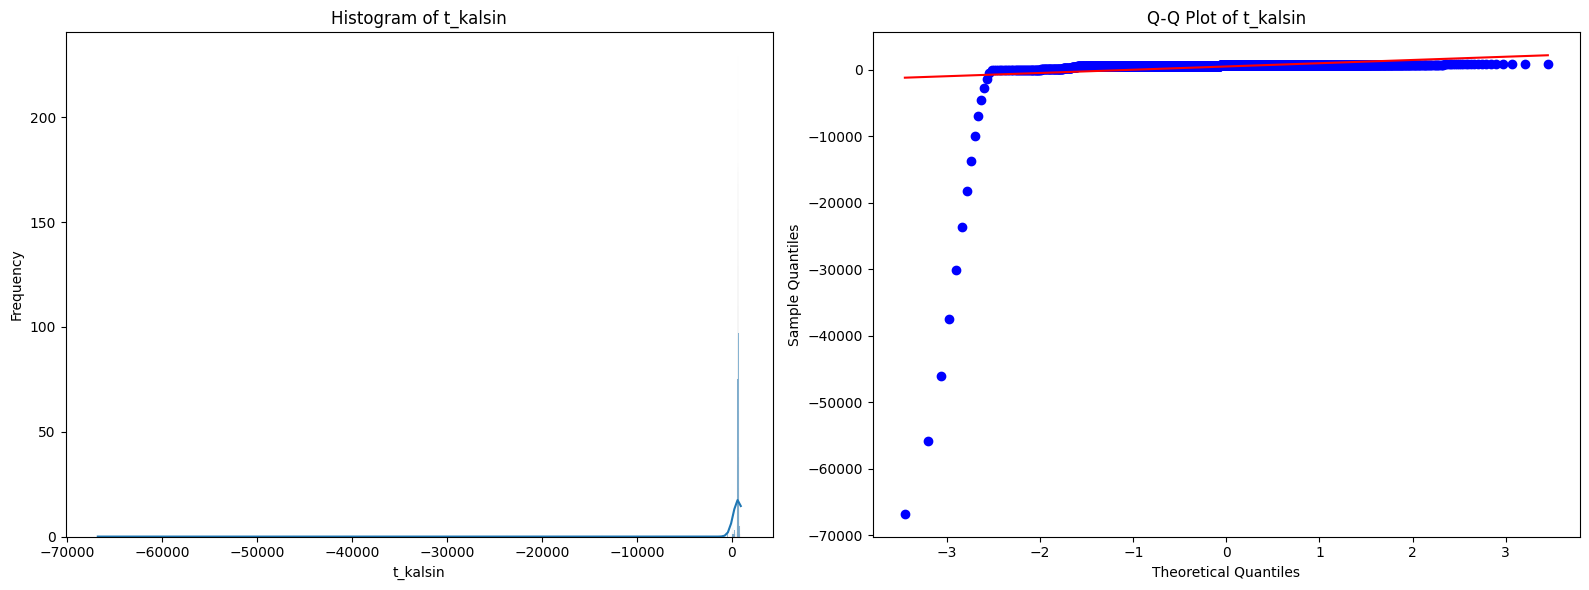

Distribution Category: non-normal distribution


In [259]:
distribution_category = determine_distribution(filtered_intersection_df['t_kalsin'], 't_kalsin')
print(f"Distribution Category: {distribution_category}")

In [260]:
# Fungsi untuk mendeteksi dan menghapus outlier berdasarkan Z-Score
def remove_outliers_zscore(df, column, threshold=3):
    z_scores = (df[column] - df[column].mean()) / df[column].std()
    return df[np.abs(z_scores) <= threshold]

# Fungsi untuk mendeteksi dan menghapus outlier berdasarkan IQR
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Daftar kolom dan metode untuk menghapus outlier
columns_zscore = ["ni_in", "fe_in", "mc_kilnfeed", "power_factor", "realisasi_beban", "kg_tco", "al2o3_in", "s_m", "bc", "t_kalsin"]
columns_iqr = [
    "sio2_in", "cao_in", "mgo_in", "fe_ni", "voltage_pry", "voltage_sec", 
    "current_pry", "current_sec1", "current_sec2", "current_sec3", "load", "rpm", "charge_kiln", "tdo", 
    "pry_p", "sec_p", "pry_v", "sec_v", "total_coal", "total_fuel", "a_f_ratio", "reductor_consume", 
    "t_tic162", "t_tic163", "metal_temp", "ni_met", "c_met", "si_met", "fe_met", "s_met", "ni_slag", 
    "fe_slag", "pic_161", "loi_kalsin"
]

# Menghapus outlier dari kolom yang menggunakan Z-Score
for column in columns_zscore:
    if column in filtered_intersection_df.columns:
        filtered_intersection_df = remove_outliers_zscore(filtered_intersection_df, column)

# Menghapus outlier dari kolom yang menggunakan IQR
for column in columns_iqr:
    if column in filtered_intersection_df.columns:
        filtered_intersection_df = remove_outliers_iqr(filtered_intersection_df, column)

# Hasil akhir
print("Outlier telah dihapus dari filtered_intersection_df")

Outlier telah dihapus dari filtered_intersection_df


In [261]:
filtered_intersection_df.shape

(696, 45)

In [262]:
filtered_intersection_df.to_excel('merged_table_23-24_null_filled.xlsx', index=False)